<h1>Import necessary modules</h1>

First step is to import all modules needed for consolidation (aggregation) and plotting.<br>
<b>numpy</b> is a main module that facilitates working with array data.<br>
<b>scipy <i>rankdata</i></b> does ranking of simulated results - used to rank and to get percentile for each element in the array<br>
<b>scipy <i>percentileofscore</i></b> used to get percentile of a value (e.g. Pmean, or other values) from simulated array

In [1]:
import numpy as np
from scipy.stats import rankdata, percentileofscore
import matplotlib.pyplot as plt

<h1>Defining functions</h1>

Next step is to define necessary functions that will be run during calculation and simulation.<br>
All functions can be split into 2 categories:<br>
1. Function wiht underscore "_" are internal functions and used inside other functions;<br>
2. Functions that can be referenced by the user of this notebook to execute required task. These functions also can be categorized with the following logics:<br>
<tab>2.1. Functions that do calculation or simulation;</tab><br>
<tab>2.2. Functions that do plotting.</tab><br>

Each function has description that explains its functionality.<br>


In [2]:
def _get_quantile(data):
    #method that returns percentile of each element in the array
    #return is of the same shape and type as inputs
    data_rank = rankdata(data)
    return (1-(1/data_rank.max())*(data_rank-0.5))


def _simulate_outcomes(Pg, HIIP):
    #method simulated outcomes returning an array of 1 (succes) or 0 (fail) outcomes 
    #shape of the output is the same as input's HIIP
    shape = HIIP.shape
    outcome = np.zeros(shape = shape)
    for i in range (0, Pg.size):
        #function returns 0 or 1 based on their probability - probability of 1 is Pg and probability of 0 is 1-Pg
        outcome[:,i] = np.random.choice([0, 1], size=(shape[0],), p=[1-Pg[i], Pg[i]])
    return outcome

def calculate_outcomes_for_independent_events(events, chance, special_symbol = "'"):
    #method to theoretically calculate all available outcomes, COS
    #can be used for further aggregation of mean reserves
    #this method is for independent events
    #events are names of prospects or reservoirs - string format
    #chance is cos array for each event
    chance_matrix = np.zeros((2**events.size, events.size))
    outcomes = np.empty((2**events.size, events.size), dtype = '<U32')
    mask = np.zeros((2**events.size, events.size))
    indexes = np.arange(0, 2**events.size, 1)
    for i in range(events.size):
        indexes =  np.reshape(indexes, (2**(i+1), int(2**events.size/(2**(i+1)))))
        for j in range(indexes.shape[0]):
            if(j % 2 == 0):
                outcomes[indexes[j], i] =  events[i]
                chance_matrix[indexes[j], i] =  chance[i]
                mask[indexes[j], i] =  1
            else:
                outcomes[indexes[j], i] = np.char.add(events[i],special_symbol)
                chance_matrix[indexes[j], i] =  1-chance[i]
                mask[indexes[j], i] =  0
    chance_outcomes = np.prod(chance_matrix, axis=1)
    p_success = np.sum(chance_outcomes[:-1])
    return outcomes, mask, chance_matrix, chance_outcomes, p_success


def calculate_outcomes_for_dependent_events(events, chance, chance_dependent, special_symbol = "'"):
    #method to theoretically calculate all available outcomes, COS
    #can be used for further aggregation of mean reserves
    #this method is for partially dependent events
    #events are names of prospects or reservoirs - string format
    #chance is cos array for each event
    #chance_dependent is a float of dependent part in COS
    outcomes, mask, chance_indepedent_matrix, _, _ = calculate_outcomes_for_independent_events(events, chance/chance_dependent, special_symbol=special_symbol)
    chance_dependent_matrix = np.full(2**events.size, chance_dependent)
    chance_outcomes = np.prod(chance_indepedent_matrix, axis=1) * chance_dependent
    p_success = np.sum(chance_outcomes[:-1])
    return outcomes, mask, chance_dependent_matrix, chance_indepedent_matrix, chance_outcomes, p_success

def calculate_conditional_cos(Pg, Pg_independent):
        #in case elements of Pg (COS) are dependent and influence each other conditional COS should be calculated.
        #2 arrays are calculated: 1. Pg in case of fail, 2. Pg in case of succes
        conditional_pg_fail = np.zeros(shape = (Pg.size-1, Pg.size-1))
        conditional_pg_success = np.zeros(shape = (Pg.size-1, Pg.size-1))
        conditional_pg_fail[0] = (1-Pg_independent[0])/(1-Pg[0])*Pg[1:]
        conditional_pg_success[:,:] = Pg_independent[1:]
        for i, pg in enumerate(conditional_pg_fail[1:]):
            #conditional pg_fail is calculated in case the previous zone (above) has failed
            #pg is updated with fail of independet parameters of Pg
            conditional_pg_fail[i+1][i+1:] = (1-Pg_independent[i+1])/(1-Pg[i+1])*conditional_pg_fail[i][i+1:]
            #conditional pg_success calculated in case the previous zone (above) has discovery
            #all dependent parameters assumed to be 1 and pg is equal to independent part of Pg
            conditional_pg_success[i+1][:i+1] = 0.
        return conditional_pg_fail, conditional_pg_success

def consolidate_outcomes(Pg, HIIP, mode = 'independent', Pg_independent = None):
    #the method multiplies simulated array of outcomes (0, 1) with the array of HIIP
    #outputs are aggregation of HIIP (based on outcomes and CoS of each zone), quantiles, successful outcomes only and cos 
    #consolidation possible with 2 modes: Pg dependent and Pg fully independent
    if mode == 'independent':
        #individual zone Pg used
        outcomes = _simulate_outcomes(Pg, HIIP)      
    elif mode == 'dependent':
        #individual zone Pg and its independent part used to calculate arrays of conditional Pg
        conditional_pg_fail, conditional_pg_success = calculate_conditional_cos(Pg, Pg_independent)
        #first simulate outcomes for all zones
        outcomes = _simulate_outcomes(Pg, HIIP)
        #chack 1st zone on fail and success and create mask of ids
        mask_ids_fail = np.where(outcomes[:, 0] == 0)[0]
        mask_ids_success = np.where(outcomes[:, 0] != 0)[0]
        #check every outcome zone by zone sequentially
        for i in range (0, outcomes.shape[1]-1):
            #temporary ids of the original mask
            temp_ids_fail = np.where(outcomes[mask_ids_fail, i] == 0)
            temp_ids_success = np.where(outcomes[mask_ids_success, i] != 0)
            #real ids of outcomes
            mask_ids_fail = mask_ids_fail[temp_ids_fail]
            mask_ids_success = mask_ids_success[temp_ids_success]
            #simulate outcomes with updated conditional Pg (success or fail)
            outcomes[mask_ids_fail, i+1:] = _simulate_outcomes(conditional_pg_fail[i, i:], outcomes[mask_ids_fail, i+1:])
            outcomes[mask_ids_success, i+1:] = _simulate_outcomes(conditional_pg_success[i, i:], outcomes[mask_ids_success, i+1:])   
    #multiply outcomes and HIIP and get the sum of resulted product
    consolidated_HIIP = HIIP * outcomes
    summed_HIIP = consolidated_HIIP.sum(axis=1)
    quantile_summed_HIIP = _get_quantile(summed_HIIP)
    successful_outcomes = summed_HIIP[summed_HIIP != 0]
    quantiles_successful_outcomes =  _get_quantile(successful_outcomes)
    #cos is ratio of successfull outcome and all simulated outcomes (including dry holes)
    cos = successful_outcomes.size/summed_HIIP.size
    return summed_HIIP, quantile_summed_HIIP, successful_outcomes, quantiles_successful_outcomes, cos

def get_consolidation_statistics(HIIP, quantiles, truncation=False):
    #calculate consolidation statistics: quantiles, min, max, mean
    #truncation on P1 and P99 can be applied for successful outcomes
    quantiles = np.sort(quantiles)[::-1]
    successful_outcomes = HIIP[HIIP != 0]
    if truncation:
        #truncating successfull outcomes with min=P99 and max=P01
        truncation_limit = np.quantile(successful_outcomes, [0.01, 0.99])
        successful_outcomes = successful_outcomes[(successful_outcomes>=truncation_limit[0]) & (successful_outcomes<=truncation_limit[1])]
    quantiles_hiip = np.empty(shape = len(quantiles))
    mean_quantile =  1-percentileofscore(successful_outcomes, successful_outcomes.mean())/100
    quantiles_hiip = np.quantile(successful_outcomes, 1-np.array(quantiles))
    return  quantiles_hiip, successful_outcomes.min(), successful_outcomes.mean(), mean_quantile

def get_commercial_success(HIIP, mcfs, quantiles):
    #commercial success is calculated based on the mcfs on the field level
    #truncation applied for the successful outcomes based on mcfs
    successful_outcomes = HIIP[HIIP != 0]
    successful_outcomes_trunc = successful_outcomes[successful_outcomes>mcfs]
    quantile_trunc = _get_quantile(successful_outcomes_trunc)
    quantile_mcfs = 1-percentileofscore(successful_outcomes, mcfs)/100
    quantiles_trunc_hiip, successful_outcomes_trunc_min, successful_outcomes_trunc_mean, trunc_mean_quantile = get_consolidation_statistics(successful_outcomes_trunc, quantiles)
    return successful_outcomes_trunc, quantile_trunc, quantile_mcfs, quantiles_trunc_hiip, successful_outcomes_trunc_min, successful_outcomes_trunc_mean, trunc_mean_quantile

def plot_hiip_distribution(hiip, hiip_truncated, quantile_hiip, quantile_hiip_truncated, hiip_mean, hiip_mean_quantile, hiip_trunc_mean, quantile_hiip_trunc_mean, title, ax):
    #plotting hiip on a logit scale plot
    ax.set_yscale('logit')
    ax.set_xscale('log')
    ax.set_title(f'HIIP distribution - {title}')
    ax.set_ylim(0.01,0.99)
    ticks = [.01,.02,.05,.1,.20,.30,.4,.5,.6,.7,.8,.9,.95,.98,.99]
    labels = ['P01','P02','P05','P10','P20','P30','P40','P50','P60','P70','P80','P90','P95','P98','P99']
    ax.set_yticks(ticks, labels=labels)
    ax.invert_yaxis()
    ax.grid(True, which = 'major', color = 'gray', linestyle = '-')
    ax.set_ylabel('Cumulative Probability')
    ax.set_xlabel('HIIP, BCM')
    ax.plot(hiip, quantile_hiip, 'b.', markersize = 0.5, label = 'HIIP')
    ax.plot(hiip_truncated, quantile_hiip_truncated, 'r.', markersize = 0.5, label = 'HIIP commercial')
    ax.plot(hiip_mean, hiip_mean_quantile,'.',color='black', markersize = 10, label = 'HIIP mean')
    ax.plot(hiip_trunc_mean, quantile_hiip_trunc_mean,'.',color='blue', markersize = 10, label = 'HIIP commercial mean')
    ax.legend()

def plot_bars_hiip_vs_chance (quantiles_hiip, mean_hiip, min_hiip, quantiles, mean_quantile, cos,  title, ax):
    #generate labels of categories / bars based on the input data: quantiles + mean + Min and Max
    categories = np.sort(np.append(quantiles, mean_quantile))[::-1]
    quantile_indexes = [np.argwhere(categories == quantile).item() for quantile in quantiles]
    quantile_indexes = np.array(quantile_indexes)
    mean_quantile_index = np.argmax(categories == mean_quantile).item()
    categories_char = np.char.add('P', ((np.array(categories)*100).astype('int16')).astype('<U20'))
    categories_char[mean_quantile_index] = categories_char[mean_quantile_index] + '(Pmean)'
    categories_char = np.insert(categories_char, [0], ['At least 1 discovery'])
    
    #create array of hiip according to categories
    hiip = np.zeros(shape = categories_char.size)
    hiip[quantile_indexes+1] = quantiles_hiip
    hiip[mean_quantile_index+1] = mean_hiip
    hiip[0] = min_hiip

    bars = ax.bar(categories_char, hiip, label = 'Resources')
    ax.bar_label(bars, np.round(hiip, 2), color = 'black', fontweight = 'bold')
    ax.set_title(f'{title}')
    ax.set_ylabel('Resources, BCM')
    ax2 = ax.twinx()
    ax2.set_ylabel('Probability of Exceeding')
    ax2.set_ylim(bottom = 0)
    
    cos_array = np.zeros(shape = categories_char.size)
    cos_array[quantile_indexes + 1] = cos * np.array(quantiles)
    cos_array[mean_quantile_index + 1] = cos * mean_quantile
    cos_array[0] = cos

    ax2.plot(categories_char, cos_array, color = 'red', label = 'Chance')
    for xy in zip(categories_char, cos_array):
        ax2.annotate('%.3f' % xy[:][1], xy=xy, textcoords='data', fontweight = 'bold', color = 'red')
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0,1.07))


def plot_outcomes_comparison(hiip, quantile_hiip, hiip_successful, quantile_hiip_successful, hiip_commercial,  quantile_hiip_commercial, title, ax):
    #plot all outcomes for comparison on a linear scale plot
    ax.plot(hiip, quantile_hiip, '.', label = 'All outcomes')
    ax.plot(hiip_successful, quantile_hiip_successful, '.', label = 'Successful outcomes')
    ax.plot(hiip_commercial, quantile_hiip_commercial,'.', label = 'Commercial outcomes')
    ax.legend()
    ax.grid()
    ax.set_title(f'{title}')
    ax.set_ylim((0,1))
    ax.set_xlim((0,hiip.max()))
    ax.set_xlabel('HIIP, BCM')
    ax.set_ylabel('Probability')

<h1>Running calculations</h1>

Here we will consider 2 possible scenarios:<br>
1. Prospects (or zones) are independent; <br>
2. Prospects (or zones) are dependent.

<h3>Independent prospects</h3>

Assume we have 3 independent prospects (events) that are characterized with Pg and HIIP distributions (the number of prospects can be different ). Then the task to consolidate HIIP taking into account chances of success can be done with following steps:<br>
1. Define an array with Prospect names (independent events);<br>
2. Define an array with Chances of success (Pg) for each prospect;<br>
3. Define an array of HIIP simulated values for each prospect.<br>

<i>*Consolidation allows to sum up all possible outcomes (in a sequence of independent events 1->2->3) accounting for prospects' chance of success</i>

In [3]:
prospects = np.array(['A', 'B', 'C'])
Pg = np.array([0.63, 0.28, 0.21]) #individual
number_of_prospects = 3
number_of_trials = 10000
#simulating HIIP values following lognormal distribution with assumed mean=2.3 and sigma=0.69
#for simplicity all 3 prospects have similar distribution parameters
HIIP = np.random.lognormal(2.3, 0.69, (number_of_trials, number_of_prospects))

We will use previously defined functions to execute following steps:<br>
1. Simulate possible outcomes;<br>
2. Plot the results.<br>

In [4]:
#quantiles will be used to get statistics for specific quantiles. Can be modified /  extendend.
quantiles =  [0.99, 0.9, 0.5, 0.1, 0.01]
#mcfs stays for minimum commercial field size. It can be modified. Should be used to truncate resulted distribution by its values. To ignore mcfs should be set to 0. 
mcfs = 9
summed_HIIP, quantile_summed_HIIP, successful_outcomes, quantiles_successful_outcomes, cos = consolidate_outcomes(Pg, HIIP)
quantiles_hiip, successful_outcomes_min, successful_outcomes_mean, mean_quantile = get_consolidation_statistics(successful_outcomes, quantiles, truncation = False)
successful_outcomes_trunc, quantile_trunc, quantile_mcfs, quantiles_trunc_hiip, successful_outcomes_trunc_min, successful_outcomes_trunc_mean, trunc_mean_quantile = get_commercial_success(summed_HIIP, mcfs, quantiles)


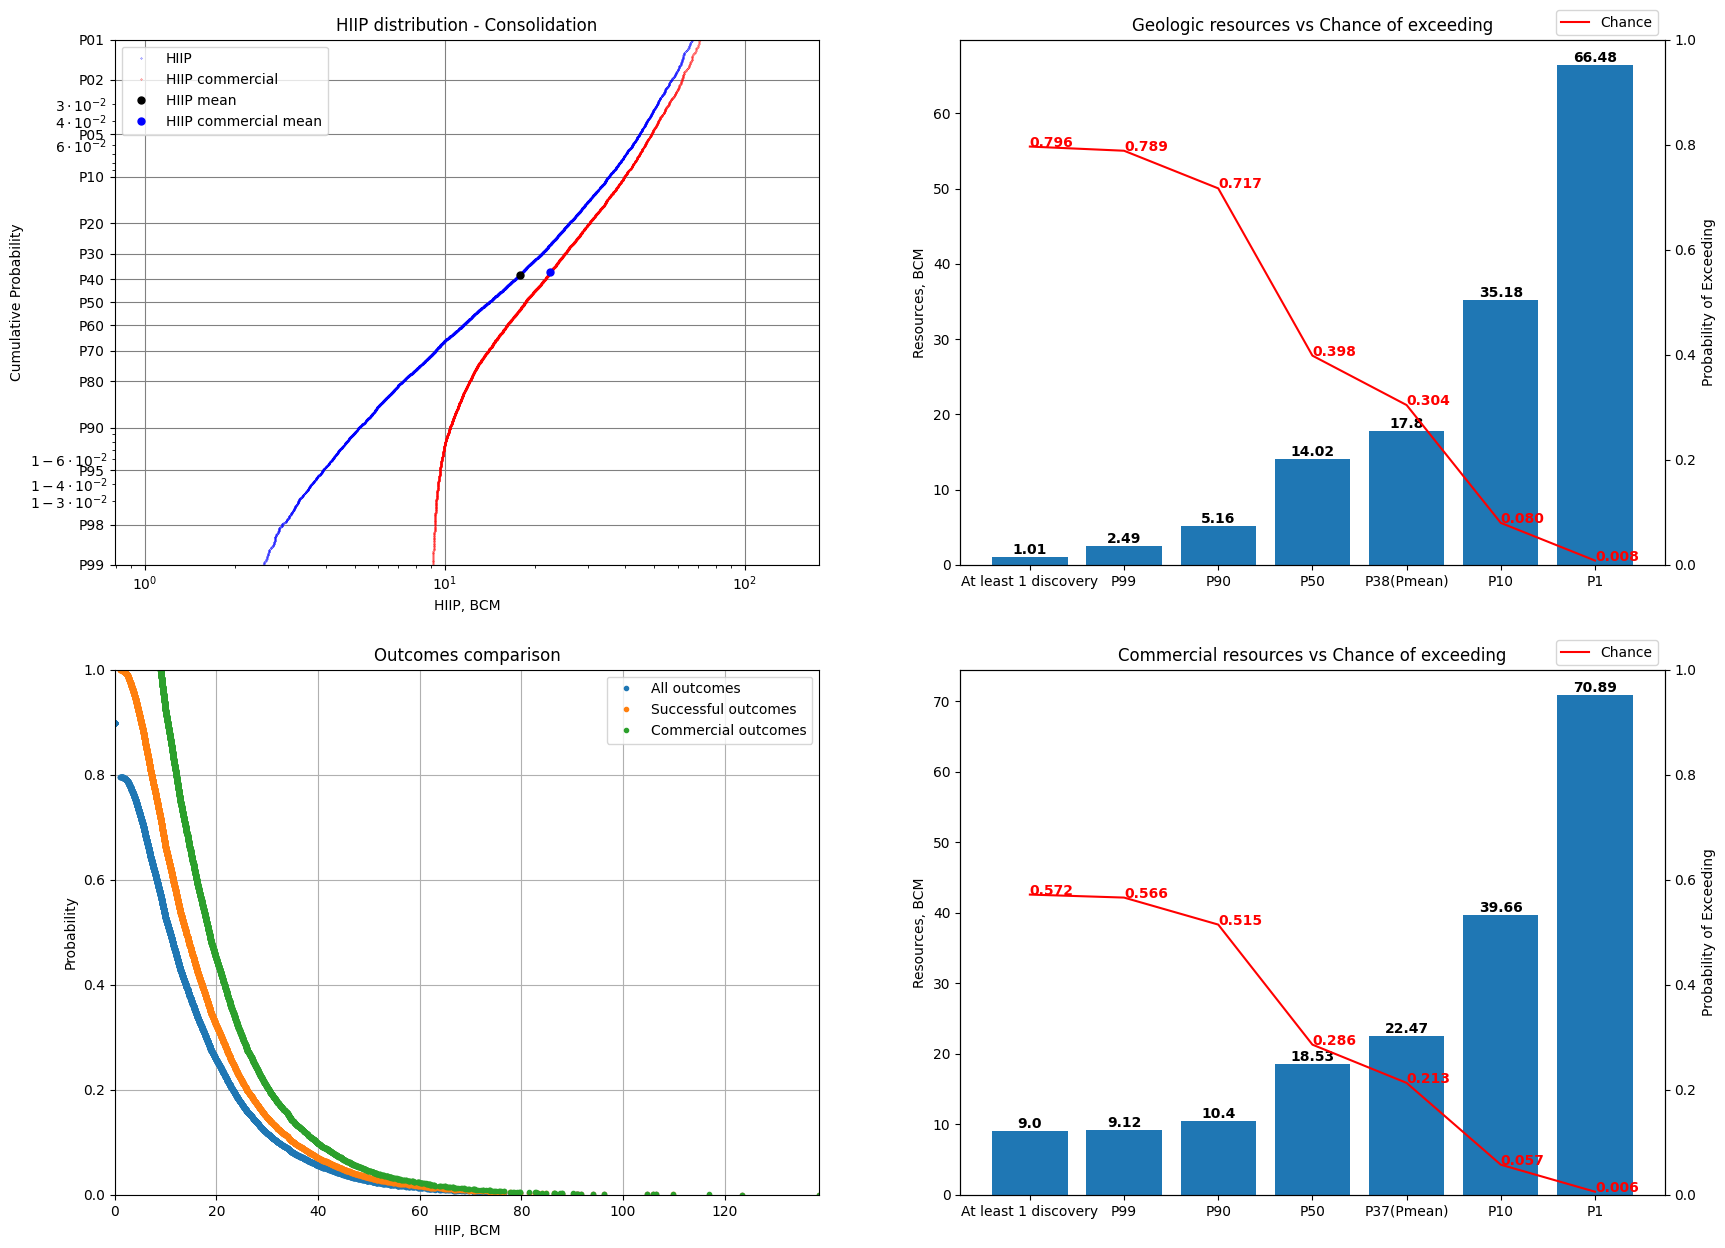

In [5]:
#this section plots the results
figure, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)
figure.set_size_inches(20, 15)
plot_hiip_distribution(successful_outcomes, successful_outcomes_trunc, quantiles_successful_outcomes, quantile_trunc, successful_outcomes_mean, mean_quantile, successful_outcomes_trunc_mean, trunc_mean_quantile, 'Consolidation', ax1)
plot_bars_hiip_vs_chance(quantiles_hiip, successful_outcomes_mean, successful_outcomes_min, quantiles, mean_quantile, cos, 'Geologic resources vs Chance of exceeding', ax2)
plot_outcomes_comparison(summed_HIIP, quantile_summed_HIIP, successful_outcomes, quantiles_successful_outcomes, successful_outcomes_trunc, quantile_trunc, 'Outcomes comparison', ax3)
plot_bars_hiip_vs_chance(quantiles_trunc_hiip, successful_outcomes_trunc_mean, successful_outcomes_trunc_min, quantiles, trunc_mean_quantile, cos*quantile_mcfs,'Commercial resources vs Chance of exceeding',ax4)

Previously defined function <i>calculate_outcomes_for_independent_events</i> allows to get information about:<br>
1. Array of possible outcomes combination - based on their names;<br>
2. Binnary mask array of outcomes with values 0 - fail and 1 - success;<br>
3. Array of probabilities for each outcome;<br>
4. Product of resulted probabilities for each combination of events;<br>
5. Chance of success of at least 1 successful event (discovery).<br>

In [6]:
calculate_outcomes_for_independent_events(prospects, Pg)

(array([['A', 'B', 'C'],
        ['A', 'B', "C'"],
        ['A', "B'", 'C'],
        ['A', "B'", "C'"],
        ["A'", 'B', 'C'],
        ["A'", 'B', "C'"],
        ["A'", "B'", 'C'],
        ["A'", "B'", "C'"]], dtype='<U32'),
 array([[1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.],
        [1., 0., 0.],
        [0., 1., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]),
 array([[0.63, 0.28, 0.21],
        [0.63, 0.28, 0.79],
        [0.63, 0.72, 0.21],
        [0.63, 0.72, 0.79],
        [0.37, 0.28, 0.21],
        [0.37, 0.28, 0.79],
        [0.37, 0.72, 0.21],
        [0.37, 0.72, 0.79]]),
 array([0.037044, 0.139356, 0.095256, 0.358344, 0.021756, 0.081844,
        0.055944, 0.210456]),
 0.7895440000000001)

<h3>Dependent Prospects</h3>

Here we repeat all steps done for Independent prospects with 1 extra step which defines dependency between prospects.

In [7]:
prospects = np.array(['A', 'B', 'C'])
Pg = np.array([0.63, 0.28, 0.21]) #individual
Pg_dependent = 0.72
Pg_independent = Pg/Pg_dependent
number_of_prospects = 3
number_of_trials = 10000
#simulating HIIP values following lognormal distribution with assumed mean=2.3 and sigma=0.69
#for simplicity all 3 prospects have similar distribution parameters
HIIP = np.random.lognormal(2.3, 0.69, (number_of_trials, number_of_prospects))

Simulate and plot outcomes

In [8]:
#quantiles will be used to get statistics for specific quantiles. Can be modified /  extendend.
quantiles =  [0.99, 0.9, 0.5, 0.1, 0.01]
#mcfs stays for minimum commercial field size. It can be modified. To ignore mcfs should be set to 0. 
mcfs = 9
summed_HIIP, quantile_summed_HIIP, successful_outcomes, quantiles_successful_outcomes, cos = consolidate_outcomes(Pg, HIIP, mode="dependent", Pg_independent=Pg_independent)
quantiles_hiip, successful_outcomes_min, successful_outcomes_mean, mean_quantile = get_consolidation_statistics(successful_outcomes, quantiles, truncation = False)
successful_outcomes_trunc, quantile_trunc, quantile_mcfs, quantiles_trunc_hiip, successful_outcomes_trunc_min, successful_outcomes_trunc_mean, trunc_mean_quantile = get_commercial_success(summed_HIIP, mcfs, quantiles)


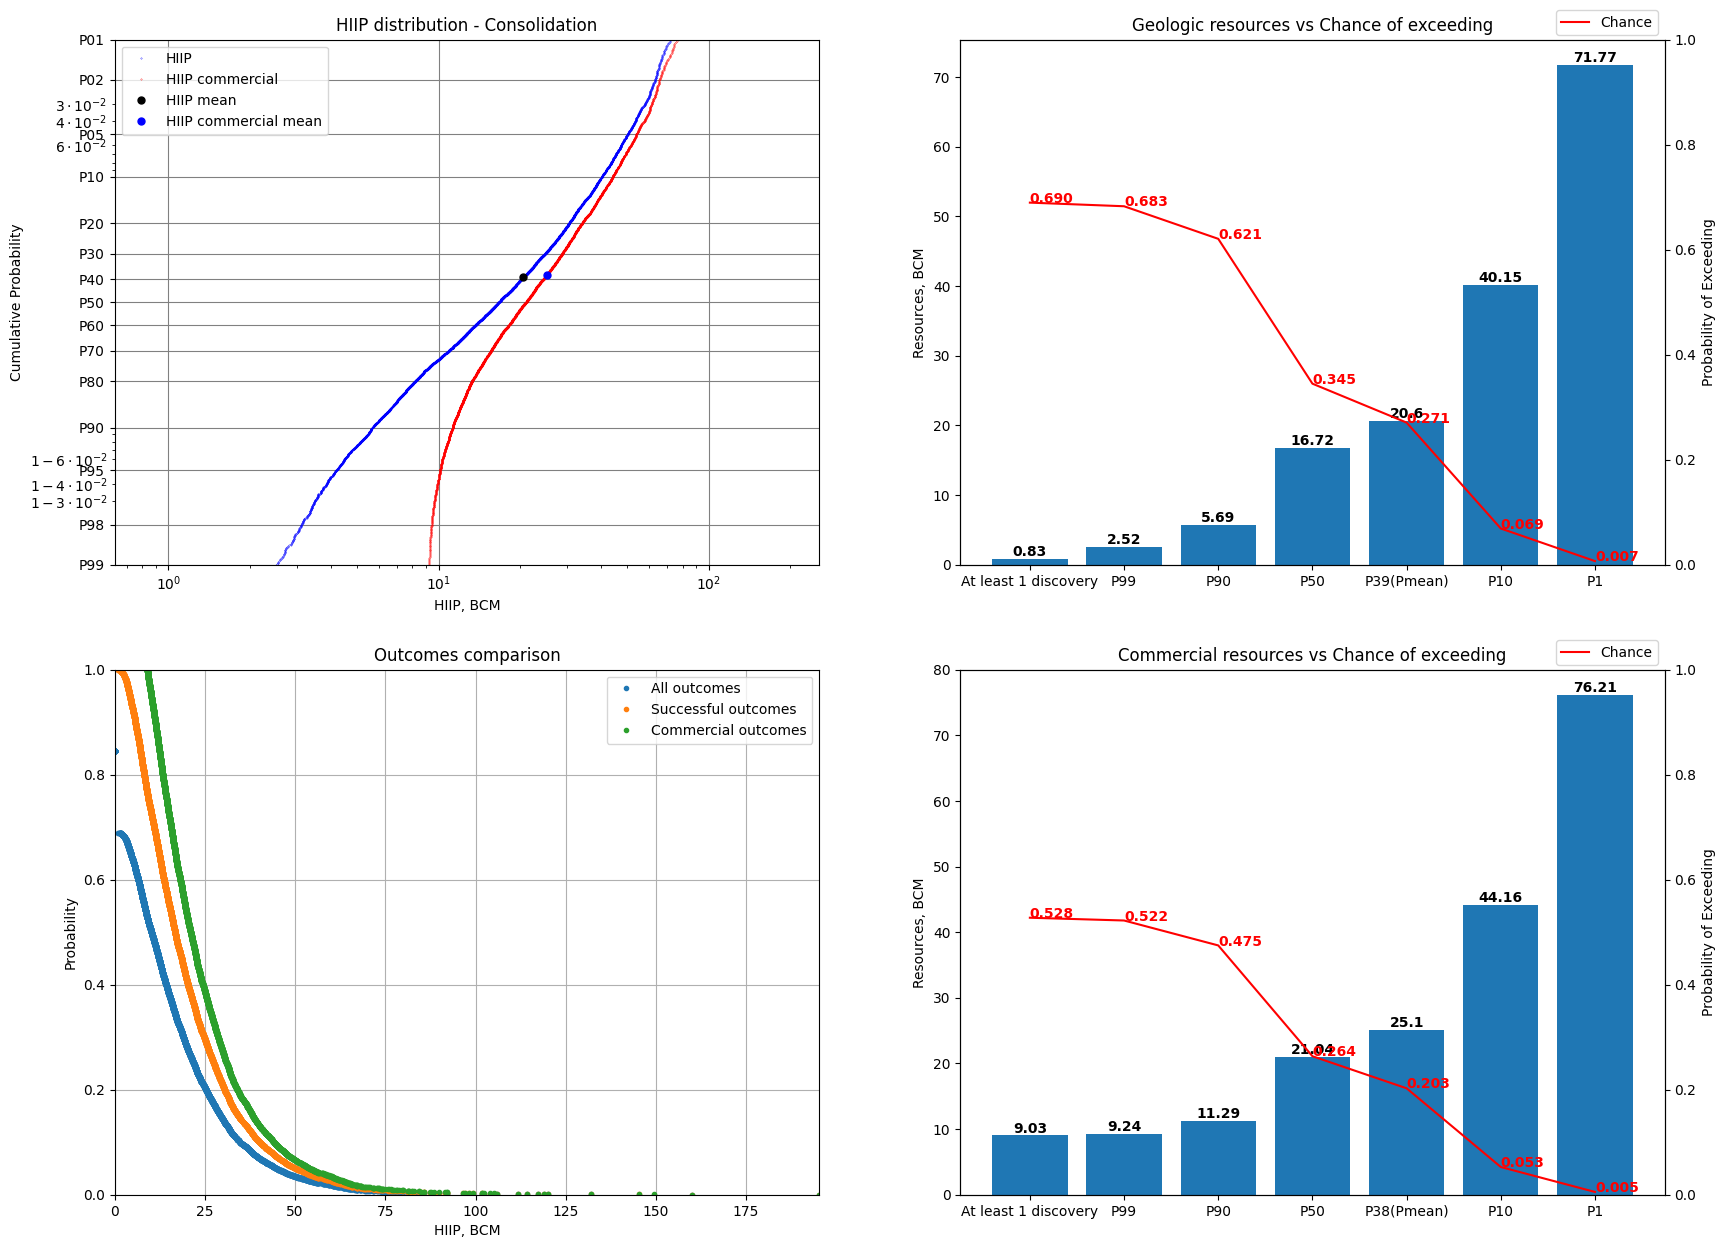

In [9]:
#this section plots the results
figure, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)
figure.set_size_inches(20, 15)
plot_hiip_distribution(successful_outcomes, successful_outcomes_trunc, quantiles_successful_outcomes, quantile_trunc, successful_outcomes_mean, mean_quantile, successful_outcomes_trunc_mean, trunc_mean_quantile, 'Consolidation', ax1)
plot_bars_hiip_vs_chance(quantiles_hiip, successful_outcomes_mean, successful_outcomes_min, quantiles, mean_quantile, cos, 'Geologic resources vs Chance of exceeding', ax2)
plot_outcomes_comparison(summed_HIIP, quantile_summed_HIIP, successful_outcomes, quantiles_successful_outcomes, successful_outcomes_trunc, quantile_trunc, 'Outcomes comparison', ax3)
plot_bars_hiip_vs_chance(quantiles_trunc_hiip, successful_outcomes_trunc_mean, successful_outcomes_trunc_min, quantiles, trunc_mean_quantile, cos*quantile_mcfs,'Commercial resources vs Chance of exceeding',ax4)

Calculation of dependent events provides similar information to calculation made for independent events. The only difference that it splits dependent and independent chances. 

In [10]:
calculate_outcomes_for_dependent_events(prospects, Pg, Pg_dependent)

(array([['A', 'B', 'C'],
        ['A', 'B', "C'"],
        ['A', "B'", 'C'],
        ['A', "B'", "C'"],
        ["A'", 'B', 'C'],
        ["A'", 'B', "C'"],
        ["A'", "B'", 'C'],
        ["A'", "B'", "C'"]], dtype='<U32'),
 array([[1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.],
        [1., 0., 0.],
        [0., 1., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]),
 array([0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72]),
 array([[0.875     , 0.38888889, 0.29166667],
        [0.875     , 0.38888889, 0.70833333],
        [0.875     , 0.61111111, 0.29166667],
        [0.875     , 0.61111111, 0.70833333],
        [0.125     , 0.38888889, 0.29166667],
        [0.125     , 0.38888889, 0.70833333],
        [0.125     , 0.61111111, 0.29166667],
        [0.125     , 0.61111111, 0.70833333]]),
 array([0.07145833, 0.17354167, 0.11229167, 0.27270833, 0.01020833,
        0.02479167, 0.01604167, 0.03895833]),
 0.6810416666666667)